Let's use another dataset than mnist to see if everything works the same

In [4]:
import torch
import numpy as np
import random
from torch import nn,tensor
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchmetrics.classification import MulticlassAccuracy 
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn import init
import fastcore.all as fc
from lib import *
from pathlib import Path

from torch.optim.lr_scheduler import OneCycleLR


In [5]:
set_seed(42)
device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

x,y = 'img','label'

@inplace
def transformi(b): 
    b[x] = [TF.to_tensor(o)-.5 for o in b[x]]

dsd = load_dataset("cifar10")
bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_datasetDict(tds, bs)
dt = dls.train

xb,yb = next(iter(dt))
xb.shape,yb[:10]


Generating test split: 100%|██████████████████████████| 10000/10000 [00:02<00:00, 4626.05 examples/s]


(torch.Size([32, 3, 32, 32]), tensor([0, 6, 0, 2, 7, 2, 1, 2, 4, 1]))

In [6]:
def show_img(im, ax=None, figsize=None, title=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figure=figsize)
    if im.shape[0] == 3:
        ax.imshow(im.permute(1, 2, 0), **kwargs)
    else:
        ax.imshow(im, **kwargs)
    if title:
        ax.set_title(title)
    ax.axis('off')
    return ax

def showImgGroup(data, grid=(3,3)):
    fig, axs = plt.subplots(grid[0], grid[1])
    imgs = data[: (grid[0]* grid[1])]
    for ax, img in zip(axs.flat, imgs):
        show_img(img.squeeze(), ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


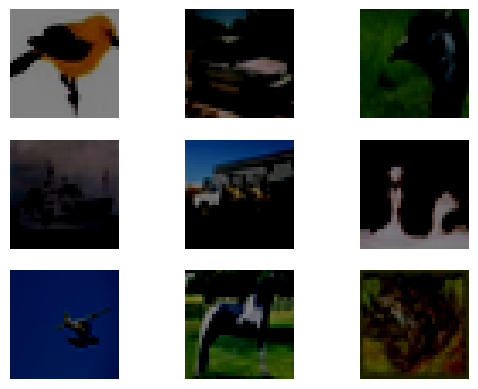

In [7]:
showImgGroup(xb[-9:], grid=(3,3))

In [8]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [11]:
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 42.6 kB/s eta 0:00:0031m41.7 kB/s eta 0:00:01


In [13]:
from accelerate import Accelerator

class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)

    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)

    def backward(self, learn): 
        sealf.acc.backward(learn.loss)


In [14]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

In [15]:
def collate_ddpm(batch):
    '''
    input: [(xi,yi), (xj,yj), ...]
    output: (tensor(X_batch_with noise), tensor(noise))
    '''
    return noisify(default_collate(batch)[x], alphabar)

def dl_ddpm(ds): 
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [16]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [17]:
class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

In [18]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [19]:
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr = lr, total_steps=tmax)
opt_func = partial(optim.Adam, eps=1e-5)

In [20]:
from diffusers import UNet2DModel
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

init_ddpm(model)
scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, total_steps=tmax, max_lr=lr)

cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricCB(),
       BatchSchedCB(scheduler), AccelerateCB(n_inp=2)] # HERE U DEFINE THE NUMBER OF INPUTS OF THE MODEL
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [21]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [27]:
model = UNet(in_channels=3, out_channels=3, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)

In [28]:
#model = UNet2DModel(in_channels=3, out_channels=3, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)

In [29]:
# learn.fit(epochs)
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
#learn.model = torch.load(mdl_path/'fashion_mnist_ddpmMineCPU.pkl')

In [30]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [31]:
samples = sample(model, (1, 3, 32, 32))
len(samples)

1000

In [32]:
# showImgGroup([samples[-1][i] for i in range(n_samples)], (3,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


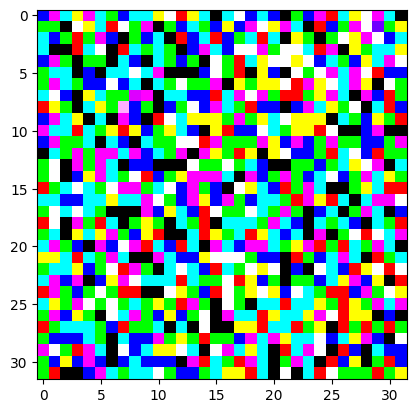

In [33]:
plt.imshow(samples[-1].squeeze().permute(1, 2, 0))

In [34]:
samples[-1].shape

torch.Size([1, 3, 32, 32])